In [1]:
import platform
import tensorflow as tf

# Windows GPU is broken with tf_agent dqn. 
if platform.uname().system == 'Windows':
    tf.config.set_visible_devices([], 'GPU')

In [2]:
import gym
import gym.utils.env_checker
import numpy as np

import flowgym
import flowgym.utils

import tensorflow as tf

import tf_agents.environments.gym_wrapper
import tf_agents.networks
import tf_agents.agents.dqn
import tf_agents.replay_buffers
import tf_agents.drivers

import tqdm.notebook as tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
env = gym.make('flowgym/WorldEnv-v0')
learning_rate = 0.001

In [4]:
obs = env.reset(seed=42)
obs

array([198.13275, 112.35288, 219.80107, 178.52621], dtype=float32)

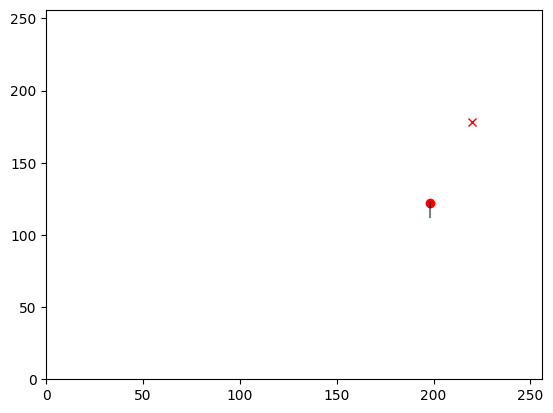

In [5]:
for i in range(10):
    env.step(1)
env.render()



# Wrap OpenAI Gym environment in Tensorflow Agent Environment
The gym environment provides a python/numpy environment. Tensorflow has slightly different names for variables (space is called spec). It also wants to wrap numpy arrays as tensors, so that they can be moved to the GPU for training. 

In [6]:
env.reset()
py_env = tf_agents.environments.gym_wrapper.GymWrapper(gym_env=env)
tf_env = tf_agents.environments.tf_py_environment.TFPyEnvironment(py_env)


In [7]:
print('Observation Spec:')
print(tf_env.time_step_spec().observation)

Observation Spec:
BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array(0., dtype=float32), maximum=array(256., dtype=float32))


In [8]:
print('Reward Spec:')
print(tf_env.time_step_spec().reward)

Reward Spec:
TensorSpec(shape=(), dtype=tf.float32, name='reward')


In [9]:
print('Action Spec:')
print(tf_env.action_spec())

Action Spec:
BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0, dtype=int64), maximum=array(3, dtype=int64))


# Create the Neural Network
We will use a QNetwork, a simple 1D perceptron layer as a training network. We could make this smarter, but for now this is sufficient. We need to combine our three imputs (velocity, target, agent) to a 1d vector. We will just  flatten and concatenate all our numbers into a (255x255x2 + 2 + 2) vector for this. 

In [10]:
# preprocessing_layers = {
#     'target': tf.keras.layers.Flatten(),
#     'agent': tf.keras.layers.Flatten()
# }
# preprocessing_combiner = tf.keras.layers.Concatenate()

q_net = tf_agents.networks.q_network.QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=(100, ),
    dtype=env.dtype,
    # preprocessing_layers=preprocessing_layers,
    # preprocessing_combiner=preprocessing_combiner
)


# Optimizer
We need to define an algorithm that will optimize. An Adam optimizer is quite common. The learning rate is a hyper parameter, specified on top of the notebook. 

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
td_errors_loss = tf_agents.utils.common.element_wise_squared_loss


# Make the Agent
Now that we have our environment, network and optimizer defined, we can now create an agent. 

In [12]:
agent = tf_agents.agents.dqn.dqn_agent.DqnAgent(
  tf_env.time_step_spec(),
  tf_env.action_spec(),
  q_network=q_net,
  optimizer=optimizer,
  td_errors_loss_fn=td_errors_loss,
  train_step_counter=tf.Variable(0))

agent.initialize()

In [13]:
time_step = tf_env.reset()
print('Time step:')
print(time_step)

action = np.array(3, dtype=np.int32)

next_time_step = tf_env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 32.79709, 115.2988 ,  94.92429, 237.25183]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0])>})
Next time step:
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 32.79709, 114.2988 ,  94.92429, 237.25183]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.00651586], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1])>})


# Policy
An agent can be trained. But it needs a policy to pick the best move based on the trained parameters. 
Let's start with a random policy. 

In [14]:
random_policy = tf_agents.policies.random_tf_policy.RandomTFPolicy(
    tf_env.time_step_spec(),
    tf_env.action_spec()
)
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [15]:
# Let's pick an action, given the current environment.
# This policy will not use the agent but pick a random action. 
time_step = tf_env.reset()
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([3], dtype=int64)>, state=(), info=())

# Replay buffer
Before we can train our agent we also need to define the data collection. Based on the collect_data_spec we can setup a replay buffer. Based on the buffer we can setup a replay observer. 

In [16]:
replay_buffer_capacity = 1000

replay_buffer = tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_capacity
)

replay_observer = [replay_buffer.add_batch]

# Driver
Now we can use the replay_observer to define a data collection driver. 

In [17]:
collect_steps_per_iteration = 10
collect_op = tf_agents.drivers.dynamic_step_driver.DynamicStepDriver(
  tf_env,
  agent.collect_policy,
  observers=replay_observer,
  num_steps=collect_steps_per_iteration
).run()

# Dataset
Now we can create a dataset from the buffer. We can pass the iterator over the dataset to store our experience.

In [18]:

dataset = replay_buffer.as_dataset(
    sample_batch_size=tf_env.batch_size,
    num_steps=2
)

iterator = iter(dataset)



Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [19]:
collect_steps_per_iteration

10

# Let's start training.

In [20]:
num_train_steps = 200
losses = []
for _ in tqdm.tqdm(range(num_train_steps), desc='gather data'):
    tf_env.reset()
    for i in range(collect_steps_per_iteration):
        time_step = tf_env.current_time_step()
        # action_step = random_policy.action(time_step)
        action_step = agent.policy.action(time_step)
        next_time_step = tf_env.step(action_step.action)
        traj = tf_agents.trajectories.trajectory.from_transition(time_step, action_step, next_time_step)

        # Add trajectory to the replay buffer
        replay_buffer.add_batch(traj)    

    experience, _ = next(iterator)
    loss = agent.train(experience=experience)
    losses.append(loss)
    if i > num_train_steps * collect_steps_per_iteration:
        break
    

gather data:   0%|          | 0/200 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


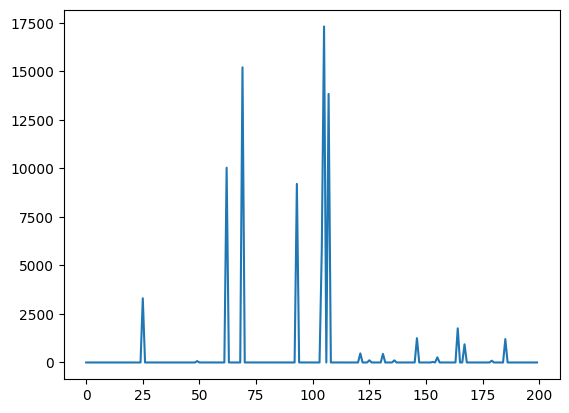

In [21]:
import pandas as pd
df = pd.DataFrame(losses)
df['loss'] = df.loss.apply(lambda x: x.numpy())
plt.plot(df['loss'])


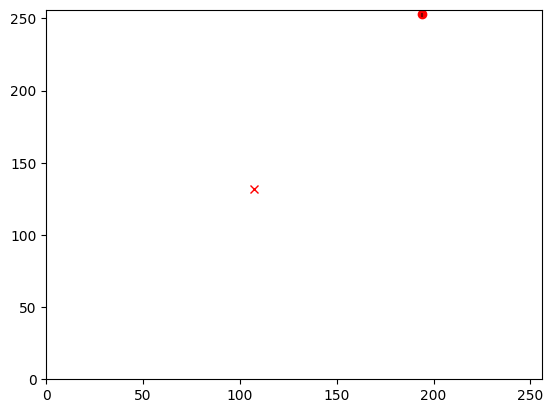

In [24]:
actions = []
env.reset()
step = tf_env.reset()
steps = [step]
positions = []
for i in range(100):
    action = agent.policy.action(step)
    step = tf_env.step(action)        
    actions.append(action)
    steps.append(step)
    

In [25]:
env.render()


In [26]:
env.reset()

array([  3.1922886, 203.78331  , 133.1789   , 104.438126 ], dtype=float32)